In [58]:
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from _utils import gen_modelID_lso, calculate_qc_metrics, get_perts, get_covs, train_one_epoch, compute_metrics
from _model import Autoencoder, Discriminator, PertDecoder, CovDecoder

In [61]:
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':2}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

strain_palette = [[100/255,190/255,180/255],'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray']

figDir = '/home/deepuser/Desktop/aqib/circuit-state/images/'


In [2]:
# HYPERPARAMETERS
HIDDEN_DIM = 512     # number of nodes in hidden layers 
BASAL_DIM = 6        # latent space dimension
WD_ae = 5.358399e-07          # weight decay for gene encoder, perturbation encoder, and gene decoder regularization
WD_p = 6.834876e-07          # weight decay for perturbation decoder regularization
WD_c = 0.0           # weight decay for discrete covariate decoder regularization
LR_ae = 1.628518            # learning rate for updating gene encoder, perturbation encoder, and gene decoder parameters
LR_p = 1.185928          # learning rate for updating perturbation decoder parameters
LR_c = 1.0           # learning rate for updating discrete covariate decoder parameters
LAM = 0.000838          # discrimination loss maximization during autoencoder updates
BATCH_SIZE = 16     # amt of data pts seen by network per parameter update
GENE_PER = 0.95      # percentile of number of zero expression genes per sample to use as threshold for sample filtering
SAMPLE_PER = 0.05    # percentile of number of samples with zero expression (per gene) to use as threshold for gene filtering

In [3]:
# device to train model on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# Load data
adata = pickle.load(open('/home/deepuser/Desktop/aqib/circuit-state/NAND_iterate/odata_NANDiterate.pkl','rb')) # log1p'd

In [5]:
# Preprocess data
samples2keep, genes2keep = calculate_qc_metrics(adata.X[:,:-9], within_gene_per=GENE_PER, within_sample_per=SAMPLE_PER)
adata = adata[samples2keep, genes2keep + [True]*9].copy() # [True]*9 is there to keep the synthetic genes

# Convert host gene expression to torch tensor
X = torch.tensor(adata.X[:,0:-9]).type(torch.float) # host gene transcriptomics

odata = adata.copy()

# Get pertubation matrix
adata, P = get_perts(adata, time_scale=(0,5), iptg_scale=(0,15), ara_scale=(0,15))
P = torch.tensor(P).type(torch.float)

# Get covariate matrix 
C = get_covs(adata)
C = torch.tensor(C).type(torch.float)

pert_names = ['Sensor_TetR',
              'Sensor_LacI',
              'Sensor_AraC',
              'Sensor_LuxR',
              'Circuit_PhlF',
              'KanR',
              'CmR',
              'YFP',
              'Circuit_IcaR',
              'time',
              'IPTG',
              'Ara']

within sample cutoff 506.0
Number of samples with high amount of zero genes: 50
within gene cutoff 131.29999999999973
Number of genes with high amount of zeros: 205


In [6]:
torch.manual_seed(1)

In [7]:
strain = 'NAND_Circuit'
train_obs = (~adata.obs.strain.isin([strain])).tolist() # cross-sample bool vector. False where .obs.strain == `strain`
test_obs = (adata.obs.strain.isin([strain])).tolist()
X_train, X_test = X[train_obs], X[test_obs]
P_train, P_test = P[train_obs], P[test_obs]
C_train, C_test = C[train_obs], C[test_obs]
print('Number of training samples: ', X_train.shape[0])
print('Number of test samples: ', X_test.shape[0])

Number of training samples:  850
Number of test samples:  107


In [8]:
# encoder input dimensions
input_dim = X.shape[1]
pert_dim = P.shape[1]
cov_dim = C.shape[1]

In [9]:
# load trained model (trained on strains other than NAND_Circuit)
model_id = 'predict_NAND'

autoenc = Autoencoder(input_dim, [HIDDEN_DIM, BASAL_DIM], pert_dim, cov_dim)
discrim = Discriminator(BASAL_DIM, pert_dim)
discrim_cov = Discriminator(BASAL_DIM, cov_dim)
pertdec = PertDecoder(pert_dim, BASAL_DIM)
covdec = CovDecoder(cov_dim, BASAL_DIM)

autoenc.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/autoenc_'+model_id+'.pt'))
discrim.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/discrim_'+model_id+'.pt'))
discrim_cov.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/discrim_cov_'+model_id+'.pt'))
pertdec.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/pertdec_'+model_id+'.pt'))
covdec.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/covdec_'+model_id+'.pt'))


<All keys matched successfully>

In [10]:
X_test_pred = autoenc(X_test,P_test,C_test).detach()

In [57]:
HUE = odata[test_obs].copy().obs.timepoint
HUE = np.array([(float(x)) for x in HUE])
HUE = np.tile(HUE[:,np.newaxis], X_test.shape[1]).reshape(-1)

4162

array([189846, 246361, 390784, ..., 119086, 138525, 337464])

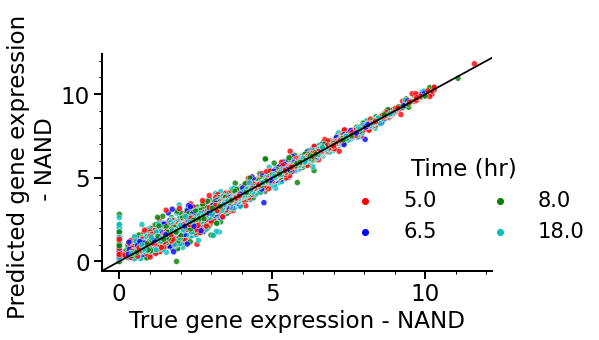

In [107]:
savefig = False
randsample = np.random.randint(0,np.array(X_test).reshape(-1,order='F').shape,
                               int(np.array(X_test).reshape(-1,order='F').shape[0]/15))
plt.figure(figsize=(7,4))
sns.scatterplot(x=np.array(X_test).reshape(-1,order='F')[randsample], 
                y=np.array(X_test_pred).reshape(-1,order='F')[randsample],
                hue=HUE[randsample],palette=['r','b','g','c'],alpha=0.8)
plt.legend(frameon=False,title='Time (hr)',fontsize=21,ncol=2,loc=(0.6,0.1))
plt.axline((0, 0), slope=1, linewidth=1.75,color='k')
plt.xlabel('True gene expression - NAND')
plt.ylabel('Predicted gene expression \n - NAND')
if savefig: 
    plt.savefig(figDir+'scatter_predict_NAND.pdf',
                bbox_inches='tight',transparent=True,dpi=300)
plt.show()
